# Diamond EP Grouping by Resolution Limit

Previously the data was grouped by spacegroups, and different clusters of high to null success rates were found. Each spacegroup yielded different predictive performance, which was better for higher success rate clusters.

However, the data remains largely overlapped/unclear. Hopefully, grouping it by different resolution limits will result in an improvement.

In [1]:
import sys
dirpath = r'C:\Users\César\PycharmProjects\Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, pd, np, plt, plot_original_data
plt.style.use("ggplot")

Dials


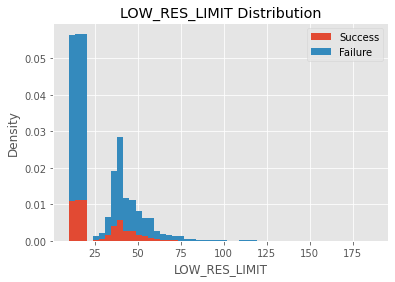

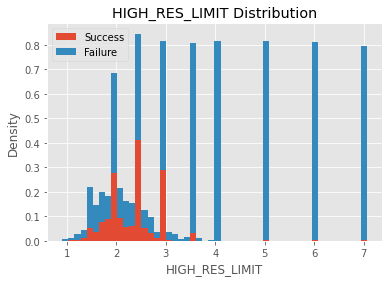

------------------------------------------------------------
3Dii


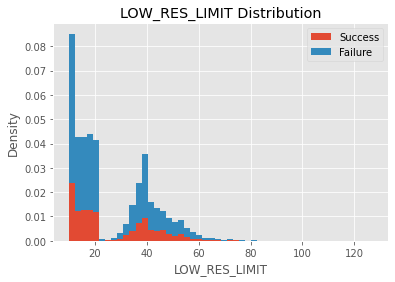

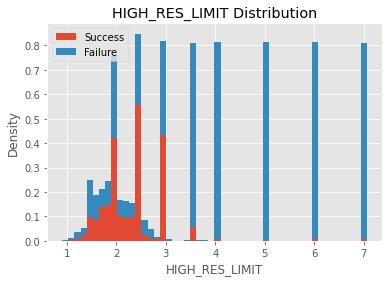

------------------------------------------------------------


In [2]:
for k, v in data.items():
    print(k.title())
    x, y = v.unpack()
    
    # separate success/failure
    mask_win, mask_lose = y == 1, y == 0
    x_win, x_lose = x[mask_win], x[mask_lose]

    # show resolutions distribution
    for col_name in ["LOW_RES_LIMIT", "HIGH_RES_LIMIT"]:
        # create stacked histograms
        fig, ax = plt.subplots()
        ax.hist([x_win[col_name], x_lose[col_name]], bins=50, stacked=True,
                density=True, label=["Success", "Failure"])

        # Aesthetics
        ax.set_xlabel(col_name)
        ax.set_ylabel("Density")
        ax.set_title(f"{col_name} Distribution")
        ax.legend()

        plt.show()
    
    print("-"*60)

- **Low Resolution Limit**: Largely distributed on the <25 area (equal on this area). Seemingly normal distribution focused on ~40.
- **High Resolution Limit**: Multiple discrete values (2, 2.5, 3, 3.5, 4, 5, 6 and 7). Smaller seemingly normal distribution around 2. Success mainly for <= 3 (fail otherwise).

When the data was downscaled for this experiment, it was done so in the following discrete values:

- **Low Resolution Limit**: None, 80, 60, 40, 20, 18, 16, 14, 12, 10
- **High Resolution Limit**: None, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7

Where None indicates the resolution was not cut. As such, we will group the data into every combination of these values as analyse it to identify the optimal resolution range.

Dials


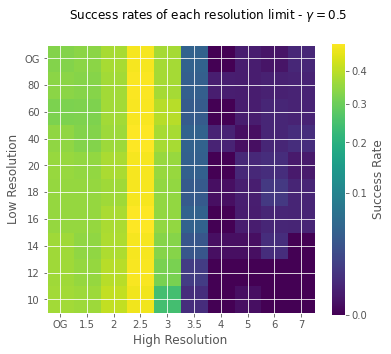

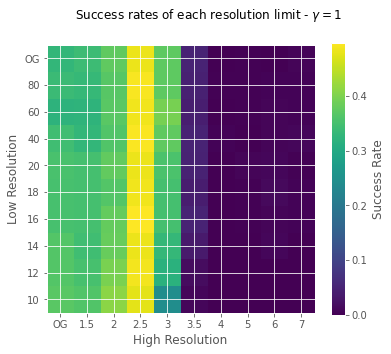

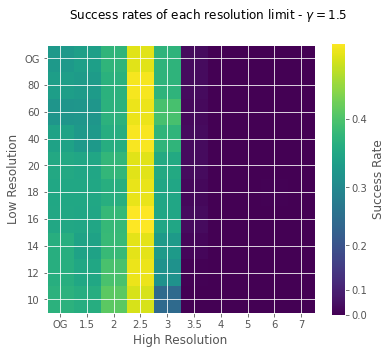

------------------------------------------------------------
3Dii


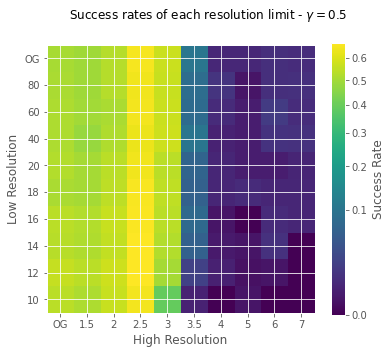

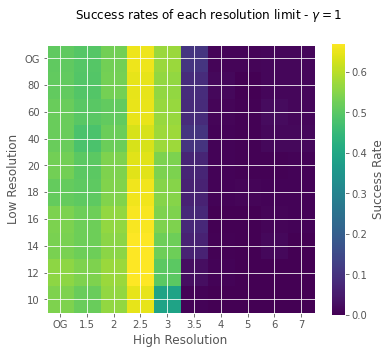

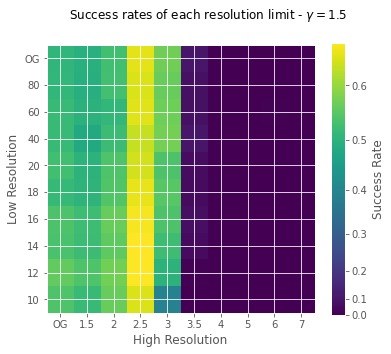

------------------------------------------------------------


In [3]:
from grouping import GroupedData
from warnings import warn
from matplotlib.colors import PowerNorm



for db_kind, datum in data.items():
    print(db_kind.title())
    x, y = datum.unpack()
    
    # group data
    groups = GroupedData(x, y)
    groups.group(x["DATASET_NAME"])
    
    # sort groups
    names = x["DATASET_NAME"].unique().tolist()
    names.sort()
    groups.sort(names, inplace=True)
    
    # get low/high resolution limits
    res_map = x[["DATASET_NAME", "RESOLUTION_LOW", "RESOLUTION_HIGH"]]
    res_map.set_index("DATASET_NAME", inplace=True)
    
    # to store success rates in [low_res, high_res] dataframe
    success_rates = []
    
    # for every low/high resolution combination
    for i, group in groups:
        # show general info
        low, high = res_map.loc[i].mean()
        #print(f"{'-' * 30}\n"
        #      f"Dataset {i}\n"
        #      f"> Resolution Limits > Low: {low:.1f}; High: {high:.1f}")
        x, y = group.unpack()

        # show success rate
        wins = y.sum()
        fails = y.size - wins
        success_rate = wins/(wins+fails)
        # print(f"> Success: {wins}; Failure: {fails} -> Success rate: {success_rate:.2%}")
        #if wins == 0:
        #    warn(f"No success detected, this ({i}) is likely particularly bad performing")
        success_rates.append(success_rate)
        
    # reshape success rates into dataframe
    lows, highs = ["OG", 80, 60, 40, 20, 18, 16, 14, 12, 10], ["OG", 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7]
    success_rates = np.array(success_rates).reshape((10, 10))
    success_rates = pd.DataFrame(success_rates, index=lows, columns=highs)
    success_rates.index.name = "Low Resolution"
    success_rates.columns.name = "High Resolution"
    
    for gamma in [0.5, 1, 1.5]:
        # show success rates colourmap
        plt.imshow(success_rates, norm=PowerNorm(gamma=gamma))
        plt.gcf().set_size_inches(6, 5)
        plt.colorbar(label="Success Rate")
        
        # labels and ticks
        plt.xticks(range(10), highs)
        plt.xlabel(success_rates.columns.name)
        plt.yticks(range(10), lows)
        plt.ylabel(success_rates.index.name)
        plt.suptitle(f"Success rates of each resolution limit - $\gamma={gamma}$")
        
        # save results
        plt.savefig(fr"../figures/resolution_grouped_success_rates_{db_kind}_gamma_{gamma}.png")
        plt.show()
    

    print("-"*60)

Say HR/LR is high/low resolution limit. Find general areas:

- **Optimal**: HR $\simeq$ 2.5 - Optimal Area
- **Average**: HR $\lt$ 2.5 and HR $\simeq$ 3
- **Limbo**: HR $\simeq$ 3.5 - Success rate pummels
- **Barely**: HR $\gt$ 3.5 and LR $\gt$ 16
- **Certain Failure**: HR $\gt$ 3.5 and LR $\lt$ 16 - Success rates $\simeq$ 0

For **optimal** and 1st **average** regions (HR $\leq$ 2.5), show slight success rate increase for **higher LR**. This trend inverts on 2nd **average** region (HR $\simeq$ 3, where **lower LR** is preferred.

Due to its incredibly low success rate, **certain failure** region is going to be removed from the following analysis. For easier analysis, **barely** and **limbo** regions could also be removed due to the same reason, however these will be left in for completeness' sake, for now.

First check stats on first (untouched) group.

Dials
------------------------------
Dataset 1
> Success Rate: 32.97%


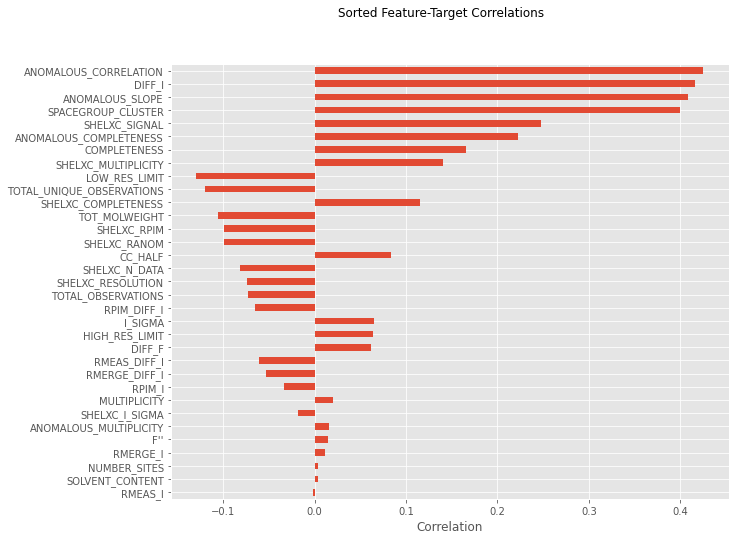

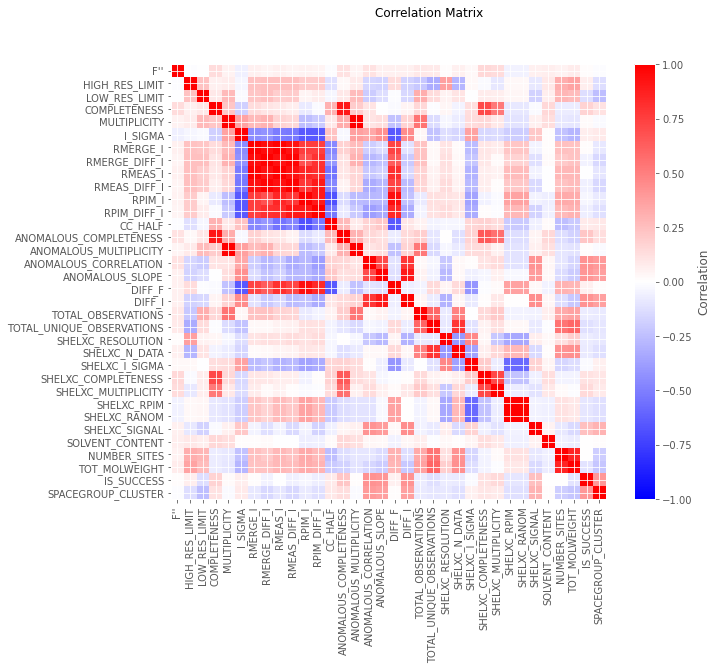

3Dii
------------------------------
Dataset 1
> Success Rate: 50.83%


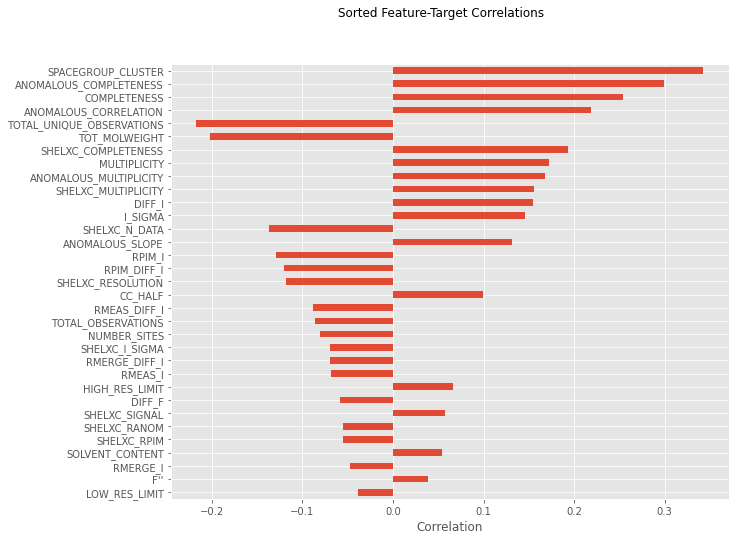

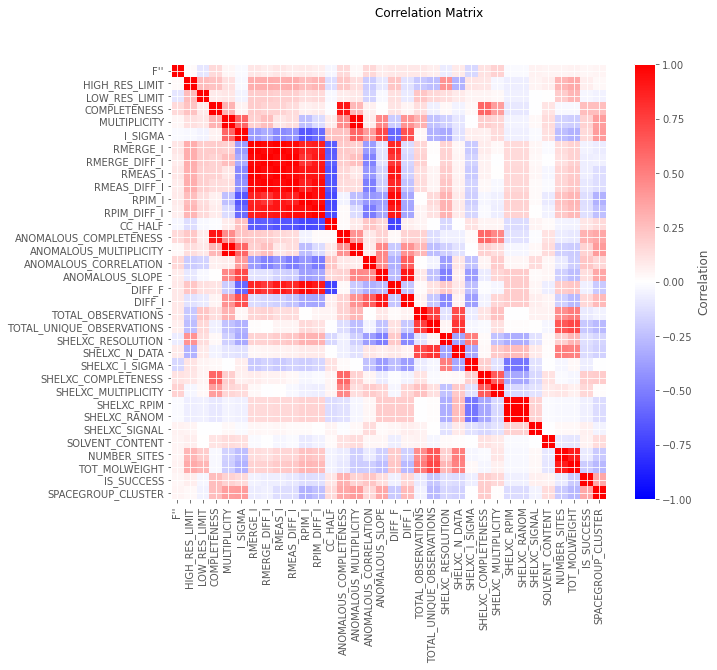

In [10]:
from matplotlib.colors import CenteredNorm
from grouping import cluster_spacegroups


for db_kind, datum in data.items():
    print(db_kind.title())
    x, y, union = datum.unpack(drop_col=["DATASET_id", "RESOLUTION_LOW", "RESOLUTION_HIGH", "SHELXC_CFOM"], union=True)

    # encode spacegroup to int based on success rate cluster
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP_CLUSTER"] = x["SPACEGROUP"].map(spc_grp_map)
    x = x.drop("SPACEGROUP", axis=1)
    union["SPACEGROUP_CLUSTER"] = union["SPACEGROUP"].map(spc_grp_map)
    union = union.drop("SPACEGROUP", axis=1)
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, union = x[mask], y[mask], union[mask]
    union = union.drop("DATASET_NAME", axis=1)
    x = x.drop("DATASET_NAME", axis=1)
    
    # print info
    print(f"{'-' * 30}\n"
      f"Dataset {i}\n"
      f"> Success Rate: {y.sum()/y.size:.2%}")
    
    # show correlation with target
    corr_target = x.corrwith(y)
    corr_target_sorted = corr_target.sort_values(key=lambda k: abs(k))
    figsize = (10, 8)
    corr_target_sorted.plot.barh(figsize=figsize)
    plt.savefig(fr"../figures/correlation_target_{db_kind}_untouched.png")
    
    # labels
    plt.xlabel("Correlation")
    plt.suptitle("Sorted Feature-Target Correlations")
    #plt.savefig(fr"../figures/correlation_target_{db_kind}_untouched.png")
    plt.show()
    
    # show correlation matrix
    corr = union.corr()
    plt.imshow(corr, cmap="bwr", norm=CenteredNorm())
    plt.gcf().set_size_inches(*figsize)
    plt.colorbar(label="Correlation")

    # labels and ticks
    plt.xticks(range(union.columns.size), union.columns, rotation=90)
    plt.yticks(range(union.columns.size), union.columns)
    plt.suptitle(f"Correlation Matrix")

    # save results
    #plt.savefig(fr"../figures/correlation_matrix_{db_kind}_untouched.png")
    plt.show()

Regarding feature-target correlations:

- **Dials** (~33% success rate):
    - 3 dominant features, **anomalous correlation/slope** (highly inter-correlated) and **DIFF I**
    - Then **SHELXC signal** and **(anomalous) completeness**
- **XDS** (~50% success rate):
    - Followed by **(anomalous/SHELXC) completeness/multiplicity**, **anomalous correlation**, **total unique observations** and **total molecular weight**
- Both:
    - DIALS correlation magnitudes **larger** than those of XDS
    - **Spacegroup cluster** also has among the highest correlations, however this is to be expected, since it represents the average success rate of that spacegroup, obtained using this same data. The true effectiveness of this true feature will be determined during estimator scoring tests.
    - **f''** and **solvent content** among the lowest correlations
    - Highly inter-correlated cluster (**RMERGE/RMEAS/RPIM (DIFF) I** average-low correlations


The following features have noticeable inter-correlation:

- **RMERGE/RMEAS/RPIM (DIFF) I** are all extremely correlated with each other
- The above are also highly anti-correlated with **I SIGMA** and **CC HALF**, which aren't correlated with each other
- **DIFF F** is highly correlated with all of the mentioned so far
- Following pairs appear very highly correlated with each other:
    - **Anomalous slope/correlation** (DIALS only), relevant since these are among the dominant features in target correlation (also on DIALS)
    - **SHELXC RPIM/RANOM**
    - **Total (unique) observations**
    - **Number of sites** and **total molecular weight**
- **Completeness/Multiplicity** are highly correlated with their respective anomalous/SHELXC versions (and slightly with each other), as expected


Now try to see weighted mean of feature-target correlations of every dataset, using the respective success rate as weights, meaning that the most successfull groups will be more impactful in the final table.

Dials
> Datasets with NaN correlations with target: [7, 27, 47]


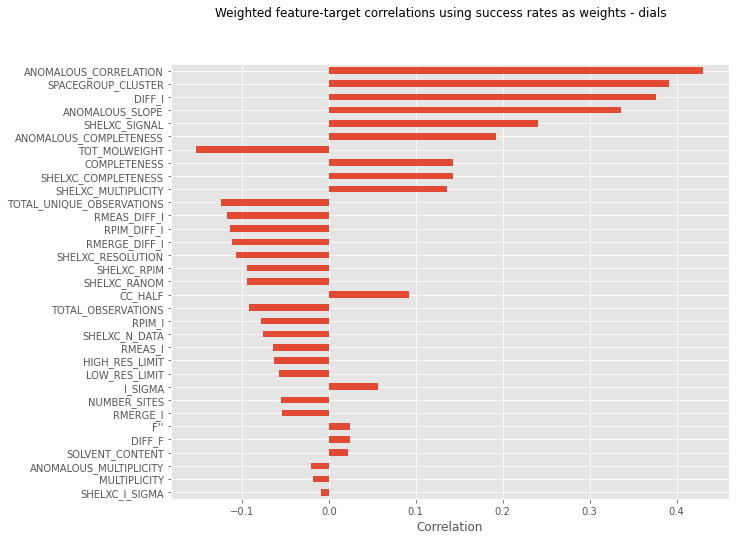

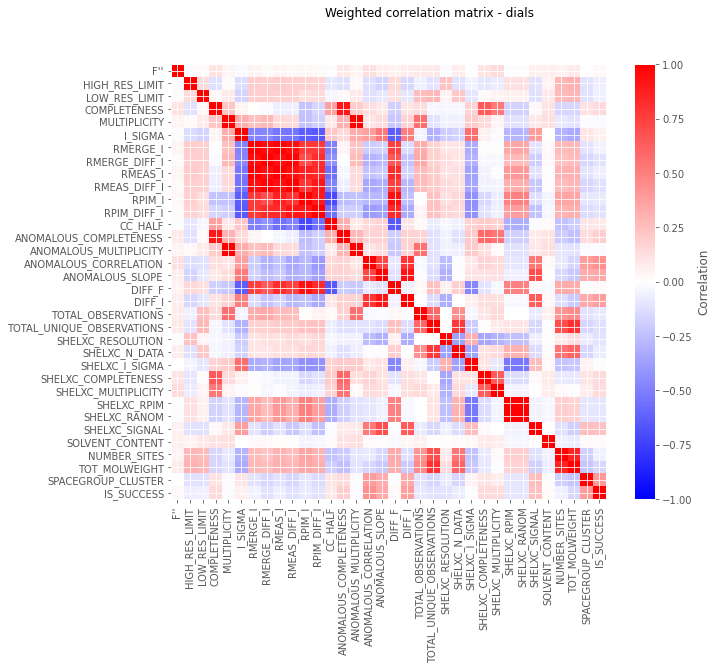

------------------------------------------------------------
3Dii
> Datasets with NaN correlations with target: []


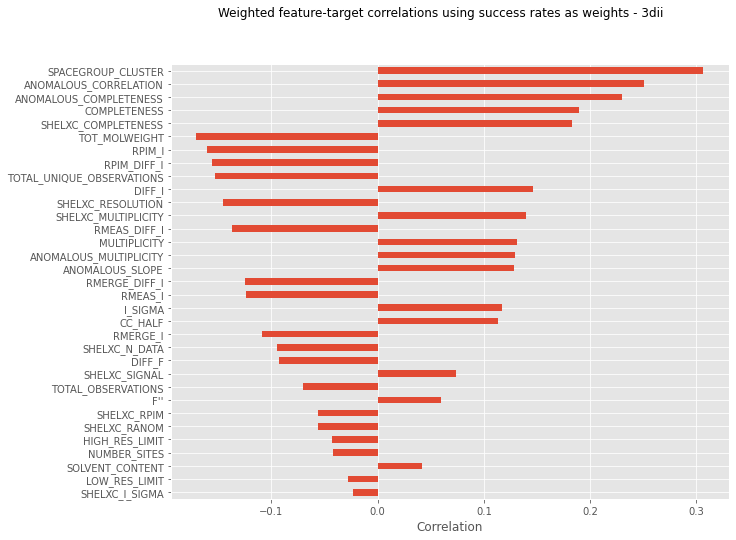

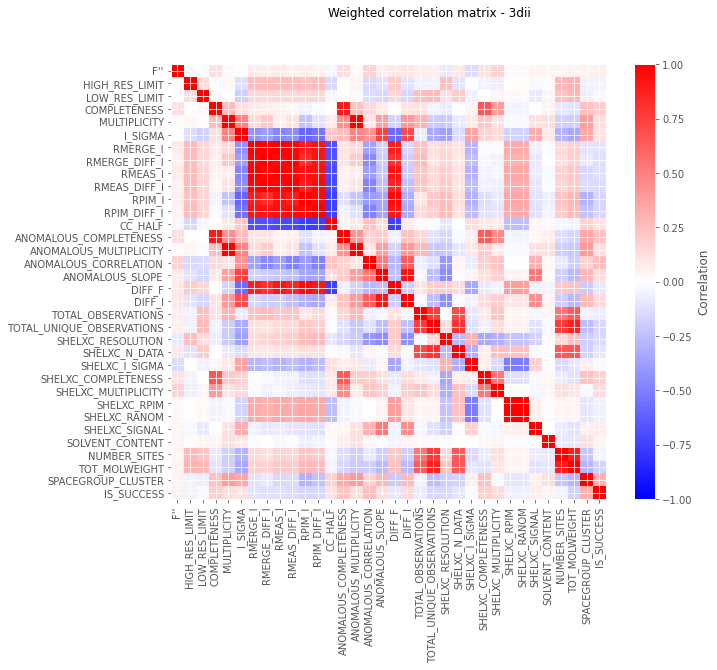

------------------------------------------------------------


In [12]:
lows, highs = ["OG", 80, 60, 40, 20, 18, 16, 14, 12, 10], ["OG", 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7]


for db_kind, datum in data.items():
    print(db_kind.title())
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"], union=True)

    # get low/high resolution limits
    res_col_names = ["DATASET_NAME", "RESOLUTION_LOW", "RESOLUTION_HIGH"]
    res_map = x[res_col_names]
    res_map.set_index("DATASET_NAME", inplace=True)
    x = x.drop(res_col_names, axis=1)

    # encode spacegroup to int based on success rate cluster
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP_CLUSTER"] = x["SPACEGROUP"].map(spc_grp_map)
    x = x.drop("SPACEGROUP", axis=1)

    # group data
    groups = GroupedData(x, y)
    groups.group(res_map.index)

    # sort groups
    grp_names = res_map.index.unique().tolist()
    grp_names.sort()
    groups.sort(grp_names, inplace=True)

    # prepare lists for correlation tables and success rates to be used as weights
    corrs, nas, weights = [], [], []

    # for every low/high resolution combination
    for i, group in groups:
        # show general info
        low, high = res_map.loc[i].mean()
        '''print(f"{'-' * 30}\n"
              f"Dataset {i}\n"
              f"> Resolution Limits > Low: {low:.1f}; High: {high:.1f}")'''
        x, y, union = group.unpack(union=True)
        n_feats = union.columns.size

        # certain failure region exception
        if low < 16 and high > 3:
            weights.append(0)
            corrs.append(np.zeros(shape=(n_feats, n_feats)))
            #print("Skipped")
            continue

        # store correlation matrix
        corr = union.corr()

        # case has NaN feature-target correlation
        if corr["IS_SUCCESS"].isna().all():
            #print(f"DATASET {i} has only NaN correlations")
            corrs.append(np.zeros_like(corr))
            nas.append(i)
            weights.append(0)
        else:
            # store success rate as weight
            corrs.append(corr.values.tolist())
            weights.append(y.sum()/y.size)


    # reshape as dataframe and create weighted average of correlations
    print(f"> Datasets with NaN correlations with target: {nas}")
    corr_weighted = np.average(np.array(corrs), weights=weights, axis=0)  # 35x35 correlation matrix
    corr_weighted = pd.DataFrame(corr_weighted, index=union.columns, columns=union.columns)
    corr_target = corr_weighted["IS_SUCCESS"].drop("IS_SUCCESS")  # isolate feature-target
    corr_target_sorted = corr_target.sort_values(key=lambda k: abs(k))

    # show feature-target correlations
    figsize = (10, 8)
    corr_target_sorted.plot.barh(figsize=figsize)
    plt.xlabel("Correlation")
    plt.suptitle(f"Weighted feature-target correlations using success rates as weights - {db_kind}")
    plt.gcf().set_size_inches(*figsize)
    plt.savefig(fr"../figures/correlation_target_{db_kind}_weighted.png")
    plt.show()

    # show feature-feature correlations
    plt.imshow(corr_weighted, cmap="bwr", norm=CenteredNorm())
    plt.gcf().set_size_inches(*figsize)
    plt.colorbar(label="Correlation")

    # labels and ticks
    plt.xticks(range(union.columns.size), union.columns, rotation=90)
    plt.yticks(range(union.columns.size), union.columns)
    plt.suptitle(f"Weighted correlation matrix - {db_kind}")

    # show results
    plt.savefig(fr"../figures/correlation_matrix_{db_kind}_weighted.png")
    plt.show()
    print("-"*60)

Results generally agree with those for the 'untouched' dataset, with a few exceptions:

- Dominated by **spacegroup cluster** and **anomalous correlation**
- **Completeness** (and variations) and **total molecular weight** with high target correlations
- **RPIM (DIFF) I** following the above in XDS, unlike its other counterparts (RMERGE/RMEAS)
- In general, **DIALS show higher correlation target correlation than XDS, even if its average sucess rate is lower**.


## Feature Importance

Now use decision trees to obtain feature importance. Start off by finding best features using RandomizedSearch.

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from scipy.stats import randint


for db_kind, datum in data.items():
    print(db_kind.upper())
    x, y, union = datum.unpack(drop_col=["DATASET_id", "RESOLUTION_LOW", "RESOLUTION_HIGH", "SHELXC_CFOM"], union=True)

    # encode spacegroup to int based on success rate
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP_CLUSTER"] = x["SPACEGROUP"].map(spc_grp_map)
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y = x[mask], y[mask]
    x = x.drop(["DATASET_NAME", "SPACEGROUP"], axis=1)

    #drop NaN
    x, y = x.dropna(axis="index"), y.dropna()
    
    # set up randomized search
    seed = 1
    param_rand = {"tree__class_weight": [None, "balanced"],
                  "tree__criterion": ["gini", "entropy"], #metric to judge reduction of impurit
                  "tree__max_features": randint(2, len(X_train.columns)+1), #max number of features when splitting
                  "tree__min_samples_split": randint(2, 20+1), #min samples per node to induce split
                  "tree__max_depth": randint(5, 20+1), #max number of splits to do
                  "tree__min_samples_leaf": randint(1, 20+1), #min number of samples in a leaf; may set to 1 anyway
                  "tree__max_leaf_nodes": randint(10, 40+1)} #max number of leaves
    
    
    for feats_drop in [[], ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]]:
        print("-"*30)
        print("-- All features" if feats_drop == [] else f"-- Dropped features: {feats_drop}")
        # split train/test datasets
        X_train, X_test, y_train, y_test = train_test_split(x.drop(feats_drop, axis=1), y, test_size=.2, stratify=y, random_state=seed)


        # try later 
        '''param_rand = {"criterion": ["gini", "entropy"],#metric to judge reduction of impurity
                      'class_weight': ['balanced', None],
                      'n_estimators': randint(100, 10000),#number of trees in forest
                      'max_features': randint(2, 48),#max number of features when splitting
                      "min_samples_split": randint(2, 20),#min samples per node to induce split
                      "max_depth": randint(5, 10),#max number of splits to do
                      "min_samples_leaf": randint(1, 20),#min number of samples in a leaf
                      "max_leaf_nodes": randint(10, 20)}#max number of leaves

        param_rand = {"base_estimator__criterion": ["gini", "entropy"],
                      'base_estimator__class_weight': ['balanced', None],
                      'base_estimator__max_features': randint(2, 6),
                      'n_estimators': randint(100, 10000),#number of base estimators to use
                      #'learning_rate': random.uniform(0.0001, 1.0),
                      'learning_rate': uniform(0.0001, 1.0),
                      "base_estimator__min_samples_split": randint(2, 20),
                      "base_estimator__max_depth": randint(1, 10),
                      "base_estimator__min_samples_leaf": randint(1, 20),
                      "base_estimator__max_leaf_nodes": randint(10, 20)}
        XGBoost, Bagging, Boosting
        https://xgboost.readthedocs.io/en/latest/

        '''

        # run randomized search
        scorer, n_iter = "f1", 50
        tree = RandomForestClassifier(random_state=seed)
        pipe = Pipeline([("scaler", StandardScaler()), ("tree", tree)])
        rand_search = RandomizedSearchCV(pipe, param_rand, n_iter=n_iter, cv=5, scoring="f1", n_jobs=4, random_state=seed)
        rand_search.fit(X_train, y_train)
        # use random state seed for reproducibility

        # prepare results
        best_params = pd.Series(rand_search.best_params_)
        topfeat = pd.Series(rand_search.best_estimator_['tree'].feature_importances_, index=X_train.columns)
        topfeat_sorted = topfeat.sort_values(ascending=False, key=lambda k: abs(k))
        y_pred = rand_search.best_estimator_.predict(X_test)

        print(f"> Best parameters:\n{best_params}\n"
              f"> Best training {scorer} score: {rand_search.best_score_:.2%}\n"
              f"> {scorer.title()} score on test (unseen) data: {rand_search.score(X_test, y_test):.2%}\n"
              f"> Feature importances:\n{topfeat_sorted}")

    
    print("-"*60)

DIALS
------------------------------
-- All features
> Best parameters:
tree__class_weight         balanced
tree__criterion             entropy
tree__max_depth                  12
tree__max_features               24
tree__max_leaf_nodes             35
tree__min_samples_leaf            2
tree__min_samples_split           2
dtype: object
> Best training f1 score: 80.04%
> F1 score on test (unseen) data: 77.30%
> Feature importances:
SHELXC_SIGNAL                0.152210
ANOMALOUS_CORRELATION        0.111507
NUMBER_SITES                 0.094395
ANOMALOUS_SLOPE              0.076497
HIGH_RES_LIMIT               0.073219
SPACEGROUP_CLUSTER           0.047846
DIFF_I                       0.045434
SOLVENT_CONTENT              0.039876
TOTAL_UNIQUE_OBSERVATIONS    0.033551
ANOMALOUS_COMPLETENESS       0.029924
LOW_RES_LIMIT                0.028806
TOT_MOLWEIGHT                0.025955
SHELXC_RESOLUTION            0.021999
SHELXC_COMPLETENESS          0.018957
TOTAL_OBSERVATIONS           0.01

A fixed random state seed was used for reproducibility. The above provides good insight:

- **DIALS**:

    - **Anomalous correlation/slope, SHELXC signal, number of sites** and **DIFF I**  dominate.
    - Followed by **high resolution limit, spacegroup cluster (unsuprising), solvent content** and **low resolution limit**

- **XDS**:
    - **Total molecular weight, number of sites** and **anomalous completeness** dominate
    - Followed by **spacegroup cluster, high resolution limit, anomalous corelation** and **total unique observations**

Noticeably, **low resolution limit** has an average importance in all tables, indicating that it has *some* relevance to successful identification.

**RMERGE/RMEAS/RPIM (DIFF) I** provide little to no relevant information, since the **model's performance is roughly the same (even slightly better) when these are removed**. As such, they can be **safely removed** from all of the following analysis.